# Install detectron2

In [1]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.14)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-apm2c7ym
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-apm2c7ym
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-cftbszc6
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-cftbszc6
     |████████████████████████████████| 266kB 12.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=47493 sha256=8ba38325c03ddd8c9f1914fa46e526454f38cf12f9c8586f04bf825450ef97d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-t2cnaw83/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel 

'1.3.1'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 1345, done.
remote: Total 1345 (delta 0), reused 0 (delta 0), pack-reused 1345
Receiving objects: 100% (1345/1345), 1.60 MiB | 3.42 MiB/s, done.
Resolving deltas: 100% (809/809), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.1MB 53kB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [Car Damage Detection Dataset](https://github.com/priya-dwivedi/Deep-Learning/tree/master/mask_rcnn_damage_detection/customImages)
which only has one class: damage.
We'll train a damage segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "damage" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [3]:
!git clone https://github.com/priya-dwivedi/Deep-Learning

fatal: destination path 'Deep-Learning' already exists and is not an empty directory.


In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools

# write a function that loads the dataset into detectron2's standard format
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(list(imgs_anns.values())[3:]):
        record = {}
        
          
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            #assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
path = "/content/Deep-Learning/mask_rcnn_damage_detection/customImages"
for d in ["train", "val"]:
    DatasetCatalog.register(path +"/" + d, lambda d=d: get_balloon_dicts(path+"/"  + d))
    MetadataCatalog.get(path+"/" + d).set(thing_classes=["damage"])
balloon_metadata = MetadataCatalog.get("car_damage")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



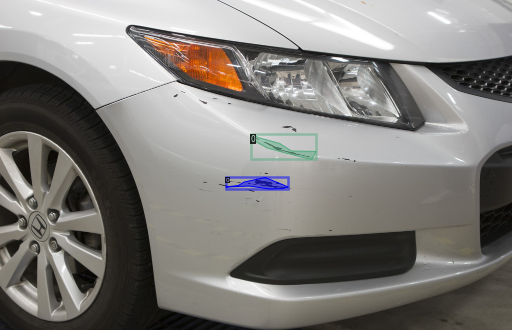

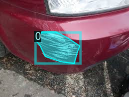

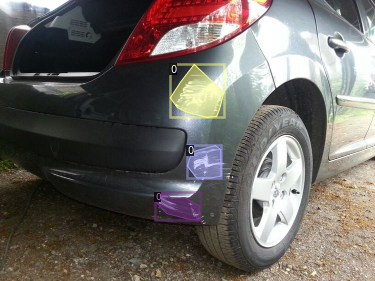

In [5]:
dataset_dicts = get_balloon_dicts(path + "/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = (path + "/train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [11/19 20:01:46 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[11/19 20:01:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
    

model_final_f10217.pkl: 178MB [00:17, 9.97MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[11/19 20:02:14 d2.engine.train_loop]: Starting training from iteration 0
[11/19 20:02:21 d2.utils.events]: eta: 0:05:11  iter: 19  total_loss: 1.792  loss_cls: 0.651  loss_box_reg: 0.387  loss_mask: 0.693  loss_rpn_cls: 0.054  loss_rpn_loc: 0.020  time: 0.3179  data_time: 0.0033  lr: 0.000005  max_mem: 2766M
[11/19 20:02:27 d2.utils.events]: eta: 0:04:58  iter: 39  total_loss: 1.696  loss_cls: 0.603  loss_box_reg: 0.360  loss_mask: 0.688  loss_rpn_cls: 0.051  loss_rpn_loc: 0.018  time: 0.3155  data_time: 0.0035  lr: 0.000010  max_mem: 2766M
[11/19 20:02:34 d2.utils.events]: eta: 0:04:55  iter: 59  total_loss: 1.677  loss_cls: 0.501  loss_box_reg: 0.365  loss_mask: 0.686  loss_rpn_cls: 0.062  loss_rpn_loc: 0.017  time: 0.3153  data_time: 0.0034  lr: 0.000015  max_mem: 2766M
[11/19 20:02:40 d2.utils.events]: eta: 0:04:51  iter: 79  total_loss: 1.583  loss_cls: 0.422  loss_box_reg: 0.431  loss_mask: 0.671  loss_rpn_cls: 0.029  loss_rpn_loc: 0.014  time: 0.3183  data_time: 0.0032  lr: 0.0

OrderedDict()

In [9]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 780), started 0:04:40 ago. (Use '!kill 780' to kill it.)

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the damage validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set the testing threshold for this model
cfg.DATASETS.TEST = (path + "/val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

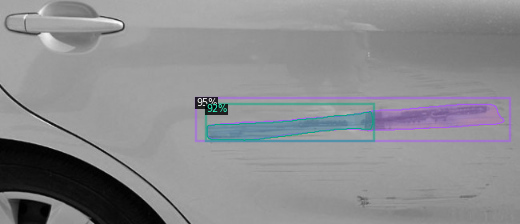

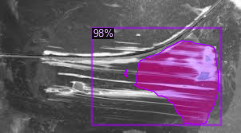

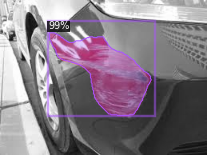

In [11]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts(path + "/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(path+ "/val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, path + "/val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [11/19 20:13:08 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for '/content/Deep-Learning/mask_rcnn_damage_detection/customImages/val'
[11/19 20:13:08 d2.data.datasets.coco]: Converting dataset annotations in '/content/Deep-Learning/mask_rcnn_damage_detection/customImages/val' to COCO format ...)
[11/19 20:13:08 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/19 20:13:08 d2.data.datasets.coco]: Conversion finished, num images: 12, num annotations: 14
[11/19 20:13:08 d2.data.datasets.coco]: Caching annotations in COCO format: /content/Deep-Learning/mask_rcnn_damage_detection/customImages/val_coco_format.json
[11/19 20:13:08 d2.data.build]: Distribution of training instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   damage   | 14           |
|            |              |
[11/19 20:13:08 d2.evaluation.evaluator]: Start inference on 12 images
[11/19 20:13:09 d2.evaluation.evaluator]: To

OrderedDict([('bbox',
              {'AP': 42.78066992219584,
               'AP50': 78.02589489718206,
               'AP75': 50.100801935397165,
               'APl': 37.217918220393464,
               'APm': 55.08250825082508,
               'APs': 0.0}),
             ('segm',
              {'AP': 27.5633725522485,
               'AP50': 75.95836002213402,
               'AP75': 17.62376237623762,
               'APl': 31.73267326732673,
               'APm': 31.59220123693041,
               'APs': 0.0})])